# Project 3: Model Building

Julian Himes  
February 2017

## Intro

In [1]:
# imports

import pandas as pd
import numpy as np
import statsmodels.api as sm
import pylab as pl
import matplotlib.pyplot as plt
from sklearn import svm

%matplotlib inline

In [2]:
# load data

df_raw = pd.read_csv("../assets/admissions.csv")
df = df_raw.dropna()

pd.options.mode.chained_assignment = None
df.prestige = df.prestige.astype(int)

print df.head()

   admit    gre   gpa  prestige
0      0  380.0  3.61         3
1      1  660.0  3.67         3
2      1  800.0  4.00         1
3      1  640.0  3.19         4
4      0  520.0  2.93         4


## Part 1. Frequency Tables

In [3]:
# frequency table for prestige and whether or not someone was admitted

df_cross = pd.crosstab(index = df["admit"], columns = df["prestige"])
df_cross.index = ["Denied", "Admitted"]
df_cross

prestige,1,2,3,4
Denied,28,95,93,55
Admitted,33,53,28,12


## Part 2. Return of dummy variables

In [4]:
handCalc = pd.get_dummies(df, columns=['prestige'], drop_first=False)
handCalc.head()

,admit,gre,gpa,prestige_1,prestige_2,prestige_3,prestige_4
0,0,380.0,3.61,0,0,1,0
1,1,660.0,3.67,0,0,1,0
2,1,800.0,4.00,1,0,0,0
3,1,640.0,3.19,0,0,0,1
4,0,520.0,2.93,0,0,0,1


#### Q: When modeling our class variables, how many do we need? 



A: One fewer than the number of values of the original variable (in this case, 3) to avoid multicollinearity.

## Part 3. Hand calculating odds ratios

In [5]:
# crosstab prestige 1 admission 
# frequency table cutting prestige and whether or not someone was admitted
p1_cross = pd.crosstab(index = handCalc["admit"], columns = handCalc["prestige_1"])
p1_cross.index = ["Denied", "Admitted"]
p1_cross

prestige_1,0,1
Denied,243,28
Admitted,93,33


#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college.

In [6]:
odds_rank1 = round(1.0 * p1_cross.iloc[1][1] / p1_cross.iloc[0][1], 2)
print "Odds(rank1): %r" % odds_rank1

Odds(rank1): 1.18


#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college.

In [7]:
odds_not1 = round(1.0 * p1_cross.iloc[1][0] / p1_cross.iloc[0][0], 2)
print "Odds(not1): %r" % odds_not1

Odds(not1): 0.38


#### 3.3 Calculate the odds ratio.

In [8]:
OR1 = round(odds_rank1 / odds_not1, 2)
print "OR(rank1): %r" % OR1

OR(rank1): 3.11


#### 3.4 Write this finding in a sentence. 

Answer: Since the odds ratio of grad school admittance given attendance at a rank 1 college is >1, we can say that going to a #1 ranked college is associated with higher rates of being admitted to grad school.

#### 3.5 Print the cross tab for prestige_4.

In [9]:
p4_cross = pd.crosstab(index = handCalc["admit"], columns = handCalc["prestige_4"])
p4_cross.index = ["Denied", "Admitted"]
p4_cross

prestige_4,0,1
Denied,216,55
Admitted,114,12


#### 3.6 Calculate the OR.

In [10]:
odds_rank4 = round(1.0 * p4_cross.iloc[1][1] / p4_cross.iloc[0][1], 2)
print "Odds(rank4): %r" % odds_rank4

odds_not4 = round(1.0 * p4_cross.iloc[1][0] / p4_cross.iloc[0][0], 2)
print "Odds(not4): %r" % odds_not4

OR4 = round(odds_rank4 / odds_not4, 2)
print "OR(rank4): %r" % OR4

Odds(rank4): 0.22
Odds(not4): 0.53
OR(rank4): 0.42


#### 3.7 Write this finding in a sentence.

Answer: Since the odds ratio of grad school admittance given attendance at a rank 4 college is <1, we can say that going to a #4 ranked college is associated with lower rates of being admitted to grad school.

## Part 4. Analysis

In [11]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(handCalc.ix[:, 'prestige_2':])
print data.head()

   admit    gre   gpa  prestige_2  prestige_3  prestige_4
0      0  380.0  3.61           0           1           0
1      1  660.0  3.67           0           1           0
2      1  800.0  4.00           0           0           0
3      1  640.0  3.19           0           0           1
4      0  520.0  2.93           0           0           1


In [12]:
# manually add the intercept
data['intercept'] = 1.0
data.head()

,admit,gre,gpa,prestige_2,prestige_3,prestige_4,intercept
0,0,380.0,3.61,0,1,0,1.0
1,1,660.0,3.67,0,1,0,1.0
2,1,800.0,4.00,0,0,0,1.0
3,1,640.0,3.19,0,0,1,1.0
4,0,520.0,2.93,0,0,1,1.0


#### 4.1 Set the covariates to a variable called train_cols

In [13]:
train_cols = ['gre', 'gpa', 'prestige_2', 'prestige_3', 'prestige_4', 'intercept']

#### 4.2 Fit the model

In [14]:
logit = sm.Logit(data['admit'], data[train_cols])
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 6


#### 4.3 Print the summary results

In [15]:
print result.summary()

                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  397
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            5
Date:                Thu, 23 Feb 2017   Pseudo R-squ.:                 0.08166
Time:                        14:19:55   Log-Likelihood:                -227.82
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                 1.176e-07
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
gre            0.0022      0.001      2.028      0.043      7.44e-05     0.004
gpa            0.7793      0.333      2.344      0.019         0.128     1.431
prestige_2    -0.6801      0.317     -2.146      0.0

#### 4.4 Calculate the odds ratios of the coefficients and their 95% CI intervals

In [16]:
lparams = np.exp(result.params)
lconf = np.exp(result.conf_int())
lconf['Odds Ratio'] = lparams
lconf.columns = ['2.5%', '97.5%', 'Odds Ratio']
print lconf

                2.5%     97.5%  Odds Ratio
gre         1.000074  1.004372    1.002221
gpa         1.136120  4.183113    2.180027
prestige_2  0.272168  0.942767    0.506548
prestige_3  0.133377  0.515419    0.262192
prestige_4  0.093329  0.479411    0.211525
intercept   0.002207  0.194440    0.020716


#### 4.5 Interpret the OR of Prestige_2.

Answer: Since the odds ratio of grad school admittance given attendance at a rank 2 college is <1, we can say that going to a #2 ranked college is associated with lower rates of being admitted to grad school.

All else held constant, you are less likely to get into grad school if you attend a rank 2 college.

#### 4.6 Interpret the OR of GPA.

Answer: Since the odds ratio of grad school admittance given an increase of 1 unit of GPA is >1, we can say that increases in GPA are associated with higher rates of being admitted to grad school.

All else held constant, you are more likely to get into grad school with a higher undergraduate GPA.

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [17]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [18]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print gres

gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print gpas

combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]), dtype=float)

[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


#### 5.1 Recreate the dummy variables

In [19]:
# recreate the dummy variables
# keep only what we need for making predictions
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
dummies = pd.get_dummies(combos['prestige'], prefix='prestige')
dummies.columns = ['prestige_1', 'prestige_2', 'prestige_3', 'prestige_4']

#### 5.2 Make predictions on the enumerated dataset

In [20]:
cols_to_keep = ['gre', 'gpa', 'prestige', 'intercept']
combos = combos[cols_to_keep].join(dummies.ix[:, 'prestige_2':])

combos['prediction'] = result.predict(combos[train_cols])

print combos.tail()

       gre       gpa  prestige  intercept  prestige_2  prestige_3  prestige_4  \
395  800.0  3.806667       4.0        1.0           0           0           1   
396  800.0  4.000000       1.0        1.0           0           0           0   
397  800.0  4.000000       2.0        1.0           1           0           0   
398  800.0  4.000000       3.0        1.0           0           1           0   
399  800.0  4.000000       4.0        1.0           0           0           1   

     prediction  
395    0.334286  
396    0.734040  
397    0.582995  
398    0.419833  
399    0.368608  


#### 5.3 Interpret findings for the last 4 observations.

Answer: Each of the last four observations (#396-399) have a perfect GRE (800) and a perfect GPA (4.0).  The difference is that each have a different prestige rank for their undergraduate - as a result, each has a different predicted probability for admission to grad school.  With GRE and GPA held constant, as the prestige rank increases (i.e. the schools get worse), the chance of grad school admission decreases.

* #396: With a perfect GRE and GPA, having gone to a rank 1 undergrad, we predict 73.4% chance of admission.
* #397: With a perfect GRE and GPA, having gone to a rank 2 undergrad, we predict 58.3% chance of admission.
* #398: With a perfect GRE and GPA, having gone to a rank 3 undergrad, we predict 42.0% chance of admission.
* #399: With a perfect GRE and GPA, having gone to a rank 4 undergrad, we predict 36.9% chance of admission.

## Bonus

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.

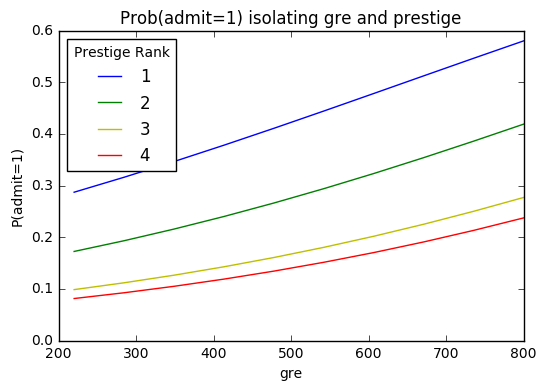

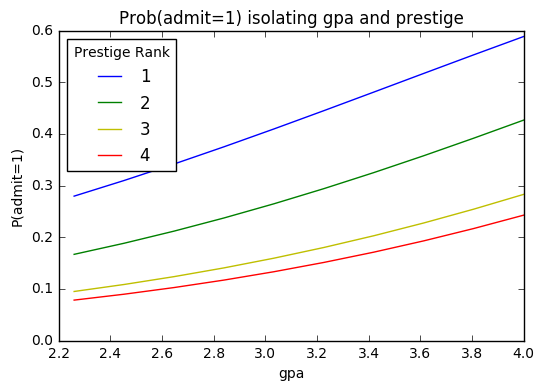

In [21]:
def cool_plot(variable):
    grouped = pd.pivot_table(combos, values=['prediction'], index=[variable, 'prestige'], aggfunc=np.mean)
    
    colors = 'rbgyrbgy'
    for col in combos.prestige.unique():
        plt_data = grouped.ix[grouped.index.get_level_values(1)==col]
        pl.plot(plt_data.index.get_level_values(0), plt_data['prediction'], color=colors[int(col)])
        
    pl.xlabel(variable)
    pl.ylabel("P(admit=1)")
    pl.legend(['1', '2', '3', '4'], loc='upper left', title='Prestige Rank')
    pl.title("Prob(admit=1) isolating " + variable + " and prestige")
    pl.show()
    
cool_plot('gre')
cool_plot('gpa')

## Super Bonus: Support Vector Machine

In [22]:
# thanks for the idea Nico!
# still wrapping my head around this one...

# fit model
X = df.loc[:, 'gre':]
y = df['admit']
model = svm.SVC()
model.fit(X , y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
# predict
SVMpredict = model.predict(X)
SVMpredict

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

In [24]:
# join to original data
newdf = pd.DataFrame.from_dict(data=SVMpredict)
newdf.columns = ['SVMpredicted']
SVMdf = df.join(newdf)
SVMdf.head()

,admit,gre,gpa,prestige,SVMpredicted
0,0,380.0,3.61,3,0.0
1,1,660.0,3.67,3,0.0
2,1,800.0,4.00,1,1.0
3,1,640.0,3.19,4,0.0
4,0,520.0,2.93,4,0.0


In [25]:
# compare predictions to actual
accuracy = round(float(len(SVMdf[SVMdf.admit == SVMdf.SVMpredicted])) / len(SVMdf), 2)
print 'SVM accuracy: %r' % accuracy

if accuracy < 0.8:
    print 'Hmm. Needs work. Keep trying!'
else:
    print 'Nice one. You understand SVM.'

SVM accuracy: 0.68
Hmm. Needs work. Keep trying!
